<a href="https://colab.research.google.com/github/aaoiii/5th-Mid-DL/blob/18%EC%A3%BC%EC%B0%A8/Getting_started_with_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Getting Started with Natural Language Processing**
### A general introduction

#### **NLP**: study that focuses on the interactions between human language and computers
  - computer sciennce, artificial intelligence, computational linuistics

### < Dataset>
- set of tweets divided into train/test set
- target column identifies whether the tweet pertains to a real disaster or not

**Goal** : create a ML model to predict whether test set tweets belong to a disaster or not ( 1 or 0 )
  - binary classification problem

### Understanding the Evaluation Metric

- measure the quality of the model
- **F1** or F score
  - 2 * (precision*recall)/(precision+recall)
  - 높을수록 좋다

    - precision : proportion of positive results that truly are positive
    
    = TP / (TP+FP)

    - recall(민감도) : ability of a test to correctly identify positive results to get the true positive rate
    
    = TP / (TP+FN)



<Why is this Useful?>
- F1 score balances the use of precision and recall
- realistic measure of test's performance by using both precision and recall
-  F score is often used in information retrieval for measuring search, document classification, and query classification performance

## 1. Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

# text processing libraries
import re                           #정규 표현식을 다루기 위한 모듈
import string                       #문자열과 관련
import nltk                         #자연어 처리를 위한 라이브러리
from nltk.corpus import stopwords   #의미가 없거나 너무 일반적인 단어들("그리고", "그런데", "이", "저" 등)로, 텍스트 처리 전후에 필터링되는 일반적인 작업

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer #텍스트 데이터를 벡터 형태로 변환하는 데 사용
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Reading Datasets

In [2]:
#Training data
train = pd.read_csv('train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


- The training data has 7613 observations and 5 features including the TARGET (the label we want to predict)

In [3]:
# Testing data
test = pd.read_csv('test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


- test data doesn't have the target column

## 3. Basic EDA
###Missing values

In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The columns denote the following:

- The text of a tweet
- A keyword from that tweet
- The location the tweet was sent from


train/test set의 location column 에 missing values가 많다

### Exploring the Target Column
  - Distribution of the Target Column
    - 1: Yes
    - 0: No

In [5]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts(),palette='rocket')

- exploring the target column

In [14]:
# A disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [15]:
#not a disaster tweet
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

- exploring the 'keyword' column
  - let's look at the top 20 keywords in training data

<Axes: xlabel='keyword'>

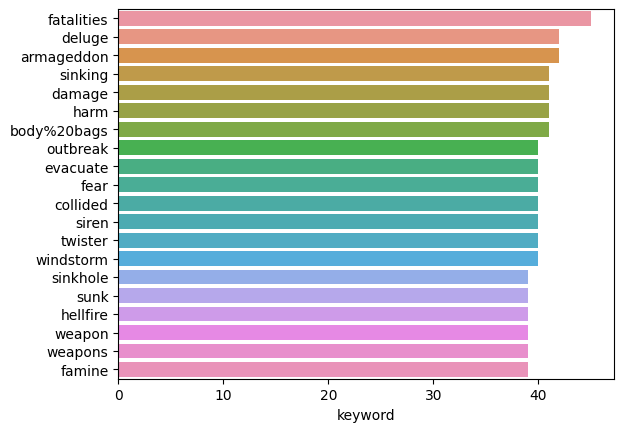

In [16]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20],
            orient='h')

Let's see how often the word 'disaster' come in the dataset and whether this help us in determining whether a tweet belongs to a disaster category or not

In [17]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

### Exploring the 'location' column
Even though the column location has a number of missing values, let's see the top 20 locations present in the dataset.

Since some of the locations are repeated, this will require some bit of cleaning.

<Axes: xlabel='location'>

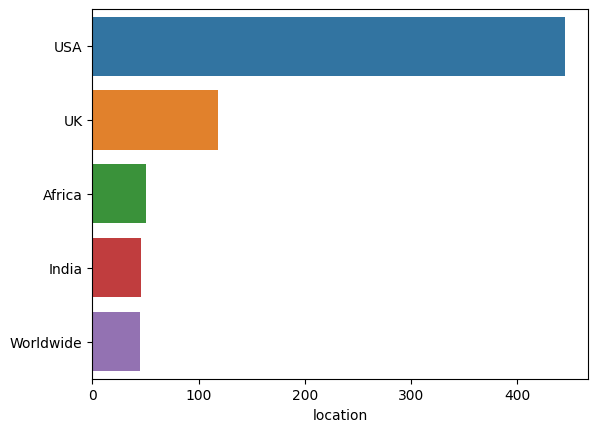

In [18]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

## 4. Test Data Preprocessing

### 1) Data Cleaning
we need to clean, tokenize, and convert our data into a matrix

- Make text all **lower case** or **uppercase** so that the algorithm does not treat the same words in different cases as different

- **Removing Noise** : everything that is not in a standard number or letter (Punctuation, Numerical values, common non-sensical text (/n) )

- **Tokenization**: process of converting the normal text strings into a list of tokens (words that we actually want)
  - **Sentence tokenizer** can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings

- **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely  =>  stop words



### More data cleaning steps after tokenization:

- **Stemming**: process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem


- **Lemmatization**:
  - A slight variant of stemming is lemmatization.
  - stemming can often create non-existent words, whereas lemmas are actual words.
  - So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma.
    - Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
  - Parts of speech tagging
  - Create bi-grams or tri-grams And more...

In [19]:
# A quick glance over the existing data
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [20]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

let's create a wordcloud of the clean text to see the most dominating words in the tweets

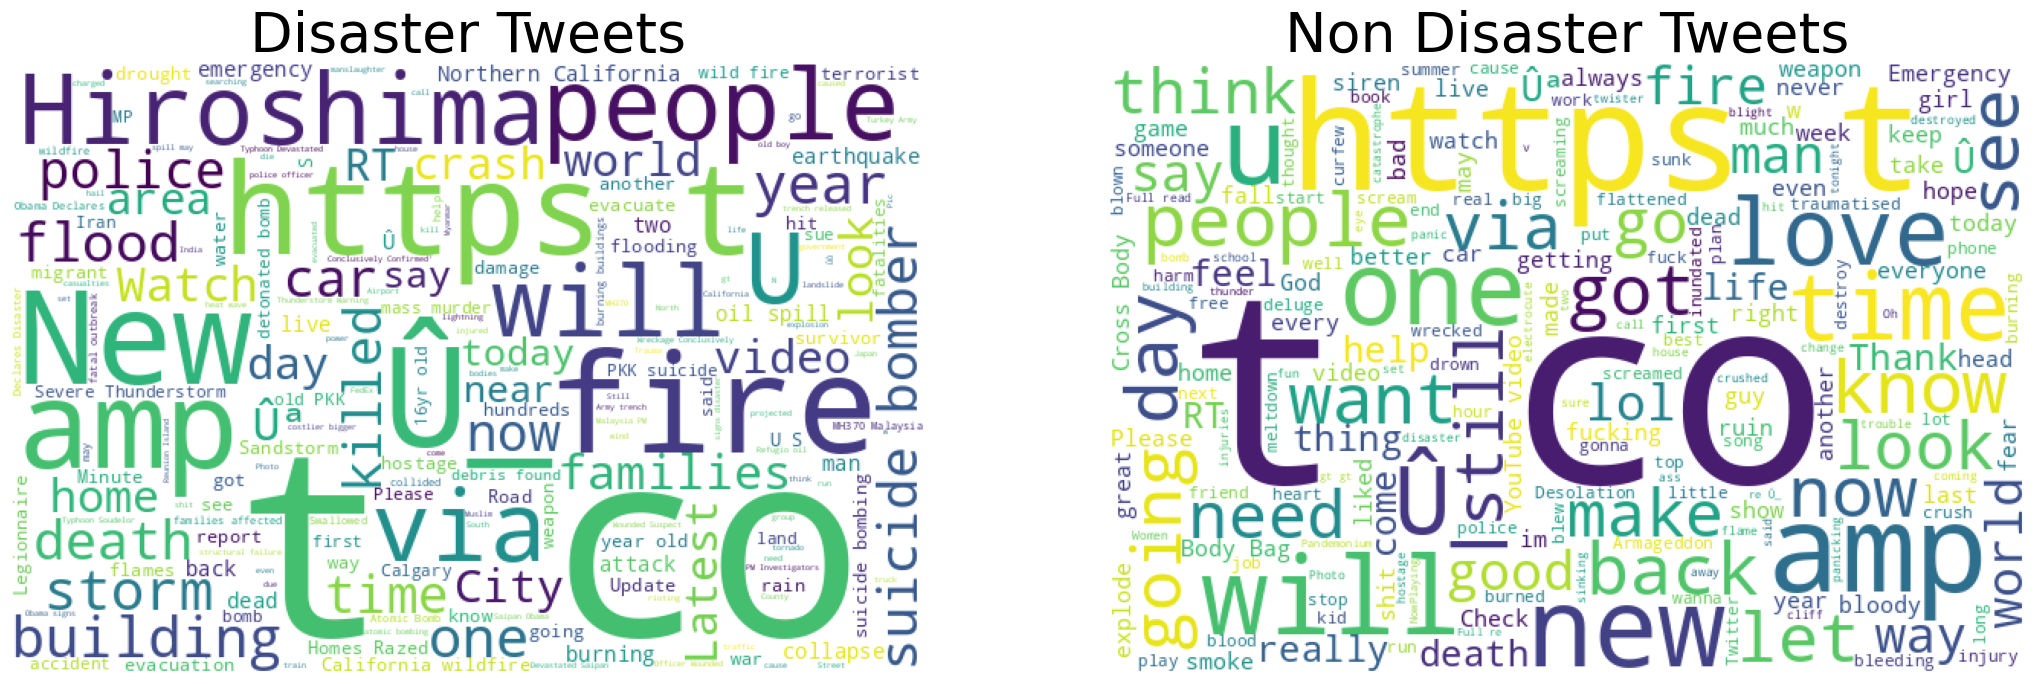

In [21]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

### 2) Tokenization

Tokenization : process that splits an input sequence into tokens

  - tokens can be a word, sentence, paragraph etc. Base upon the type of tokens we want, tokenization can be of various types, for instance

In [22]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [23]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

### 3) Stopwords Removal
let's get rid of the stopwords i.e words which occur very frequently but have no possible value like a, an, the, are etc

In [25]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language

    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words


train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


### 4) Token normalization

- **Stemming** : removing and replacing suffixes to get to the root form of the word, which is called the stem for instance cats - cat, wolves - wolv

- **Lemmatization** : Returns the base or dictionary form of a word, which is known as the lemma

In [ ]:
# Stemming and Lemmatization examples
text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

It is important to note here that stemming and lemmatization sometimes donot necessarily improve results as at times we donot want to trim words but rather preserve their original form. Hence their usage actually differs from problem to problem. For this problem, I will not use these techniques.

In [27]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


### Getting it all together- A Text Preprocessing Function
  - concluding the pre-processing part

In [28]:
# text preprocessing function
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

##5.  Transforming tokens to a vector

- we need to transform text into a meaningful vector (or array) of numbers

####**Bag Of Words**
 describes the occurrence of words within a document. It involves two things:

    - A vocabulary of known words.
    - A measure of the presence of known words.


- any information about the order or structure of words in the document is discarded and the model is only concerned with whether the known words occur in the document, not where they occur in the document


-  using scikit-learn's CountVectorizer, where every row will represent a different tweet and every column will represent a different word


####**Bag of Words - Countvectorizer Features**

- Countvectorizer converts a collection of text documents to a matrix of token counts.
- It is important to note here that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal.
- However, i did all the process manually above to just get a better understanding. Let's use a vanilla implementation of the countvectorizer without specifying any parameters.

In [29]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test["text"])

## Keeping only non-zero elements to preserve space
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


#### TFIDF Features

- A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

- One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: scoring of the frequency of the word in the current document.
      TF = (Number of times term t appears in a document)/(Number of terms in the document)

- **Inverse Document Frequency**: scoring of how rare the word is across documents.

      IDF = 1+log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

In [30]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

## 6. Building a Text Classification model
Let's create a basic claasification model using commonly used classification algorithms and see how our model performs.

**Logistic Regression Classifier**

In [31]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.62395543, 0.54545455, 0.61285008, 0.57761733, 0.70977918])

In [32]:
clf.fit(train_vectors, train["target"])

LogisticRegression()

In [33]:
# Fitting a simple Logistic Regression on TFIDF
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.61248761, 0.56688494, 0.60053619, 0.58119658, 0.71729958])

It appears the countvectorizer gives a better performance than TFIDF in this case.


**Naive Bayes Classifer**

In [34]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.65195246, 0.63197026, 0.68772961, 0.64630225, 0.73934312])

In [35]:
clf_NB.fit(train_vectors, train["target"])

MultinomialNB()

In [36]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.59405941, 0.58386219, 0.63922942, 0.60188679, 0.73866447])

In [37]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB()

**XGBoost**

In [38]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.5840708 , 0.48628885, 0.49409628, 0.50717703, 0.62988115])

In [39]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.58717435, 0.50331126, 0.52427184, 0.56102004, 0.642978  ])

**Making the submission**

In [ ]:
submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_NB_TFIDF,test_vectors)